In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import PorterStemmer
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeiakhmadulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
train = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/train.csv", on_bad_lines='skip',sep=';')
val = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/evaluation.csv", on_bad_lines='skip',sep=';')
test = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/test.csv", on_bad_lines='skip',sep=';')

In [24]:
# Function to calculate the proportion of 1's and 0's in the target column
def calculate_proportions(df):
    prop_1 = df['label'].mean()  # proportion of 1's
    prop_0 = 1 - prop_1          # proportion of 0's
    return prop_0, prop_1

In [27]:
# Calculate proportions for each dataset
prop_0_train, prop_1_train = calculate_proportions(train)
prop_0_val, prop_1_val = calculate_proportions(val)
prop_0_test, prop_1_test = calculate_proportions(test)

# Create a DataFrame for plotting
proportions = pd.DataFrame({
    'Real': [prop_0_train, prop_0_val, prop_0_test],
    'Fake': [prop_1_train, prop_1_val, prop_1_test]
}, index=['Train', 'Validation', 'Test'])


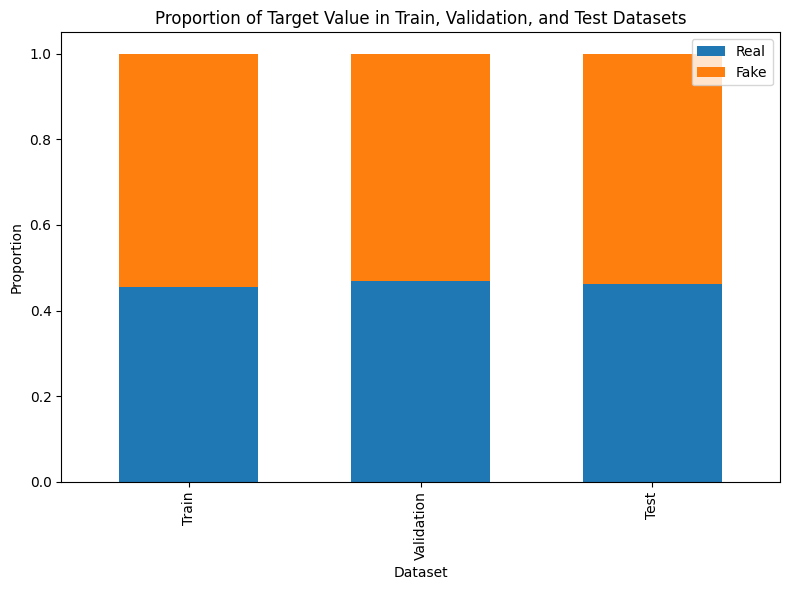

In [28]:
# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the stacked bar chart
proportions.plot(kind='bar', stacked=True, ax=ax, width=0.6)

# Add labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Target Value in Train, Validation, and Test Datasets')

# Set custom x-axis labels for each dataset
ax.set_xticklabels(['Train', 'Validation', 'Test'])

# Display the plot
plt.tight_layout()
plt.show()

In [112]:
def text_prepare(text):
    """
    Function that does a general text preparation

    Parameters:
    text: corpus of text documents

    Output:

    text without spetial characters, "stop words" in lower case and stemmed
    """
    stemmer = PorterStemmer()
    REPLACE_BY_SPACE_RE = re.compile(r'[^a-zA-Z0-9\s]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower()

    text = REPLACE_BY_SPACE_RE.sub(r' ',text)
    text = BAD_SYMBOLS_RE.sub(r'',text)
    text = [stemmer.stem(w) for w in text.split() if not w in STOPWORDS]
    
    return ' '.join(text)

In [147]:
def plot_confusion_matrix(Y_true, Y_pred):
    cm = confusion_matrix(Y_true, Y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=list(proportions.columns), yticklabels=list(proportions.columns))
    
    # Set plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

For now let's combine train and validation datasets and use them together in training

In [45]:
train["all_test"] = train['title'] + " " + train["text"]
val["all_test"] = val['title'] + " " + val["text"]
test["all_test"] = test['title'] + " " + test["text"]

In [134]:
Xtrain_all = pd.concat([train, val], axis=0)

In [136]:
X_train_cleaned = [text_prepare(x) for x in Xtrain_all["all_test"]]
# X_val_cleaned = [text_prepare(x) for x in val["all_test"]]
X_test_cleaned = [text_prepare(x) for x in test["all_test"]]

In [137]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

In [138]:
X_train_matrix = tfidf.fit_transform(X_train_cleaned)
# X_val_matrix = tfidf.transform(X_val_stemmed)
X_test_matrix = tfidf.transform(X_test_cleaned)

In [139]:
y_train = Xtrain_all["label"]
# y_val = val["label"]
y_test = test["label"]

In [140]:
svm_model = SVC(kernel='linear', random_state=42)

In [141]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
}

In [142]:
from sklearn.svm import LinearSVC

# LinearSVC is optimized for large datasets with sparse matrices
svm_model = LinearSVC(random_state=42, max_iter=10000)  # You can increase max_iter if needed

In [143]:
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1, verbose = 1)
grid_search.fit(X_train_matrix, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LinearSVC(max_iter=10000, random_state=42),
             n_jobs=-1, param_grid={'C': [0.1, 1, 10, 100]},
             scoring='precision', verbose=2)

In [144]:
best_svm_model = grid_search.best_estimator_

y_pred = best_svm_model.predict(X_test_matrix)

# Classification report to evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3753
           1       0.98      0.98      0.98      4364

    accuracy                           0.98      8117
   macro avg       0.98      0.98      0.98      8117
weighted avg       0.98      0.98      0.98      8117



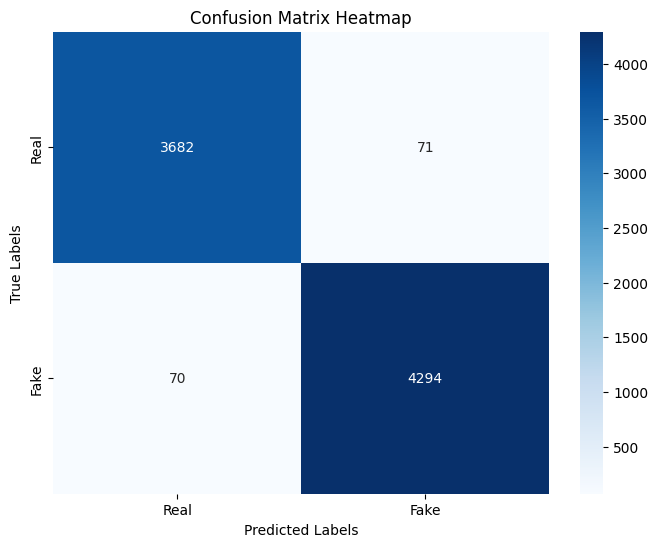

In [146]:
plot_confusion_matrix(y_test, y_pred)

In [149]:
nb_model = MultinomialNB()
nb_model.fit(X_train_matrix, y_train)

# Make predictions on the test set
y_pred_NB = nb_model.predict(X_test_matrix)

In [151]:
print("Classification Report:\n", classification_report(y_test, y_pred_NB))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.90      3753
           1       0.88      0.97      0.93      4364

    accuracy                           0.92      8117
   macro avg       0.92      0.91      0.91      8117
weighted avg       0.92      0.92      0.92      8117

[CV] END ..............................................C=0.1; total time=   2.7s
[CV] END ...............................................C=10; total time=  14.6s
[CV] END ................................................C=1; total time=   3.9s
[CV] END ...............................................C=10; total time=  13.9s
[CV] END ................................................C=1; total time=   4.0s
[CV] END ...............................................C=10; total time=  14.0s
[CV] END ..............................................C=0.1; total time=   2.4s
[CV] END ................................................C=1; total time=   3.2s
[

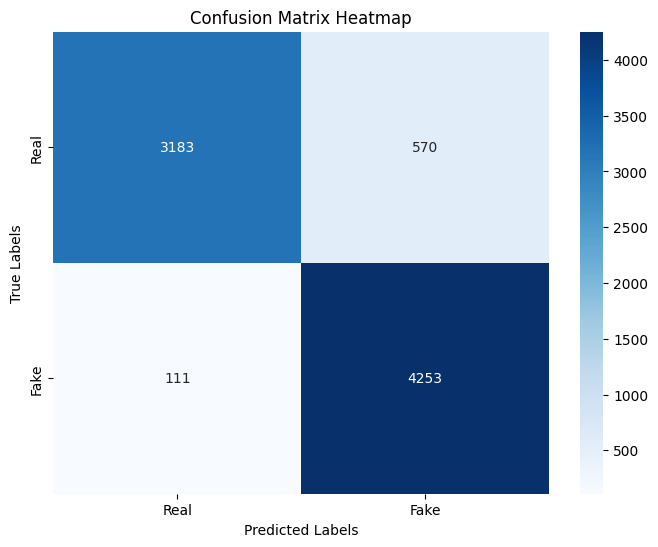

In [150]:
plot_confusion_matrix(y_test, y_pred_NB)

In [157]:
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10],            # Regularization strength
    'penalty': ['l2', 'l1'],                   # Regularization type
    'solver': ['liblinear']            # Solvers
}

grid_search = GridSearchCV(LogisticRegression(), param_grid_LR, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_matrix, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l2', 'l1'], 'solver': ['liblinear']},
             verbose=1)

In [158]:
best_lr_model = grid_search.best_estimator_

# Make predictions with the tuned model
y_pred_LR = best_lr_model.predict(X_test_matrix)

In [159]:
print("Classification Report:\n", classification_report(y_test, y_pred_LR))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      3753
           1       0.98      0.99      0.99      4364

    accuracy                           0.99      8117
   macro avg       0.99      0.99      0.99      8117
weighted avg       0.99      0.99      0.99      8117



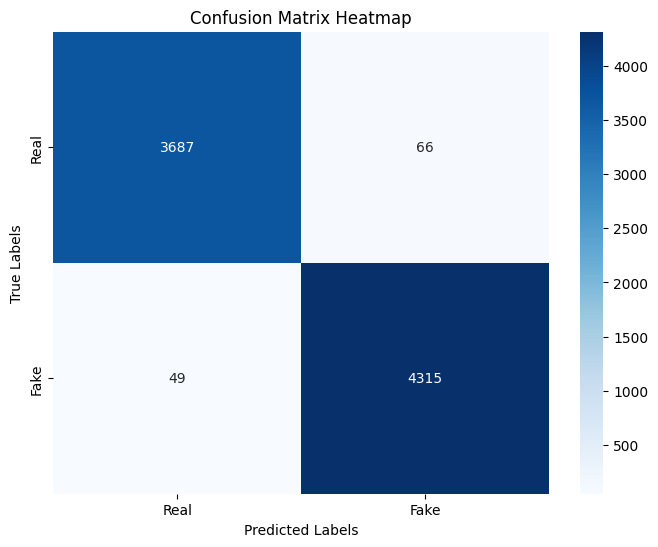

In [160]:
plot_confusion_matrix(y_test, y_pred_LR)

In [176]:
import shap

In [ ]:
explainer = shap.Explainer(best_lr_model, X_train_matrix)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_matrix)

LinearExplainer explainer: 4068it [00:36, 114.27it/s]

In [ ]:
shap.summary_plot(shap_values, X_test_tfidf, feature_names=vectorizer.get_feature_names_out())

In [170]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, LSTM, Dropout

In [162]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_cleaned)

In [163]:
X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_test_seq = tokenizer.texts_to_sequences(X_test_cleaned)

In [164]:
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=200)

In [166]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [167]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=16, validation_data=(X_test_pad, y_test))

Epoch 1/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8985 - loss: 0.2177 - val_accuracy: 0.9738 - val_loss: 0.0699
Epoch 2/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9854 - loss: 0.0438 - val_accuracy: 0.9757 - val_loss: 0.0670
Epoch 3/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9960 - loss: 0.0134 - val_accuracy: 0.9686 - val_loss: 0.1159
Epoch 4/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9983 - loss: 0.0069 - val_accuracy: 0.9734 - val_loss: 0.1065
Epoch 5/5
2030/2030 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9981 - loss: 0.0069 - val_accuracy: 0.9736 - val_loss: 0.1356


254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.1433
Test Accuracy: 97.36%


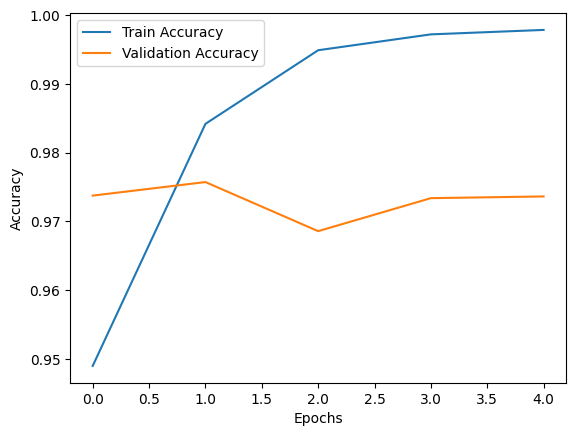

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3753
           1       0.97      0.98      0.98      4364

    accuracy                           0.97      8117
   macro avg       0.97      0.97      0.97      8117
weighted avg       0.97      0.97      0.97      8117



In [168]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions and print classification report
y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

In [172]:
model = Sequential()

# Embedding layer to convert integer sequences to dense vectors
model.add(Embedding(input_dim=5000, output_dim=128))

# LSTM layer to capture sequential dependencies in text
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))

# Dense layer for final classification
model.add(Dense(1, activation='sigmoid'))

# Model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [173]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [174]:
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/5
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 83s 81ms/step - accuracy: 0.8466 - loss: 0.3645 - val_accuracy: 0.9490 - val_loss: 0.1632
Epoch 2/5
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 78s 76ms/step - accuracy: 0.9369 - loss: 0.1897 - val_accuracy: 0.9608 - val_loss: 0.1264
Epoch 3/5
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 78s 77ms/step - accuracy: 0.9657 - loss: 0.1041 - val_accuracy: 0.9683 - val_loss: 0.0901
Epoch 4/5
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 78s 77ms/step - accuracy: 0.9792 - loss: 0.0665 - val_accuracy: 0.9725 - val_loss: 0.0771
Epoch 5/5
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - accuracy: 0.9853 - loss: 0.0462 - val_accuracy: 0.9749 - val_loss: 0.0780


254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9784 - loss: 0.0724
Test Accuracy: 97.49%


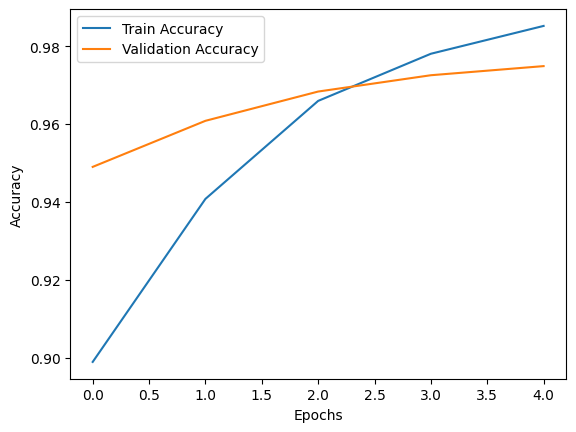

254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3753
           1       0.98      0.98      0.98      4364

    accuracy                           0.97      8117
   macro avg       0.97      0.97      0.97      8117
weighted avg       0.97      0.97      0.97      8117



In [175]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions and print classification report
y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

In [ ]:
from transformers import AutoTokenizer

# Load a pre-trained tokenizer (you can choose a different model)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Example text to tokenize
text = "Hugging Face provides an awesome library for NLP."

# Tokenize the text
tokens = tokenizer.tokenize(text)

# Print the tokens
print(tokens)

In [ ]:
pip install transformers torch